In [1]:
import io
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dropout, MaxPooling2D, Conv2D, Dense
from keras.datasets import cifar10
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from skimage.color import rgb2grey
%matplotlib inline

Using TensorFlow backend.


## 2. (Deep) CNNs for Image Colorization

### (a) This assignment uses a convolutional neural network for image colorization which turns a gray scale image to a colored image. By converting an image to grayscale, we loose color information, so converting a grayscale image back to a colored version is not an easy job. We will use the CIFAR-10 dataset. Downolad the dataset from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz.

In [0]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [78]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [0]:
X = np.vstack((X_train,X_test))
y = np.vstack((y_train,y_test))

In [0]:
y = y.flatten()

In [81]:
X.shape, y.shape

((60000, 32, 32, 3), (60000,))

### (b) From the train and test dataset, extract the class birds. We will focus on this class, which has 6000 members.

In [0]:
ind = [i for i,j in enumerate(y) if j == 2]

In [0]:
X = X[ind]
y = y[ind]

### Visualizing some images of birds

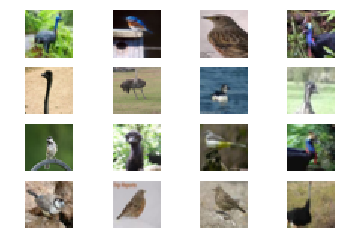

In [84]:
for i in range(0,16):
    axis = plt.subplot(4,4,i+1)
    arr = X[i]
    axis.imshow(arr)
    plt.axis('off')
plt.show()

### (c) Those 6000 images have 6000 × 32 × 32 pixels. Choose at least 10% of the pixels randomly. It is strongly recommended that you choose a large number or all of the pixels. You will have between P = 614400 and P = 6144000 pixels. Each pixel is an RGB vector with three elements.

In [85]:
X.shape, y.shape

((6000, 32, 32, 3), (6000,))

In [0]:
X = X.reshape((6144000,3))

In [87]:
X.shape

(6144000, 3)

### (d) Run k-means clustering on the P vectors using k = 4. The centers of the clusters will be your main colors. Convert the colored images to k-color images by converting each pixel’s value to the closest main color in terms of Euclidean distance. These are the outputs of your network, whose each pixel falls in one of those k classes.

In [0]:
kmeans = KMeans(n_clusters=4,random_state=0)
kmeans = kmeans.fit(X)

In [89]:
kmeans.cluster_centers_

array([[108.97036568, 108.60691289,  82.66458238],
       [206.53651167, 211.77549799, 211.39857871],
       [156.18468173, 155.51640472, 135.57285659],
       [ 49.02965771,  50.01208333,  38.57034319]])

In [0]:
X_new = X

In [91]:
X.shape

(6144000, 3)

In [0]:
for i in range(len(X)):
    X_new[i] = kmeans.cluster_centers_[kmeans.labels_[i]]

### Visualizing some images of birds after k-means

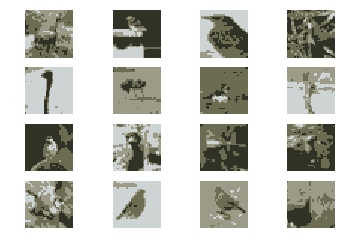

In [93]:
X_viz = X_new.reshape((6000,32,32,3))
for i in range(0,16):
    axis = plt.subplot(4,4,i+1)
    arr = X_viz[i]
    axis.imshow(arr)
    plt.axis('off')
plt.show()

The images only retain 4 colors chosen from the k-means centroid.

### One hot encoding the output classes

In [0]:
y_N = keras.utils.to_categorical(kmeans.labels_).reshape((6000,32,32,4))

### (e) Use any tool (e.g., openCV or scikit-learn) to obtain grayscale 32 × 32 × 1 images from the original 32 × 32 × 3 images. The grayscale images are inputs of your network.

In [0]:
X = X.reshape((6000,32,32,3))

In [0]:
X_N = []
for i in range(len(X)):
    X_N.append(rgb2grey(X[i]).tolist())

In [0]:
X_N = np.array(X_N)

### Visualizing some images of birds (train data) after converting to grey scale

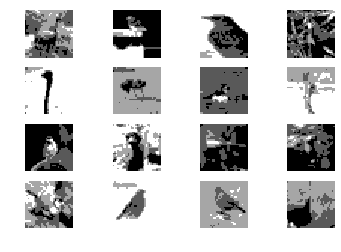

In [107]:
for i in range(0,16):
    axis = plt.subplot(4,4,i+1)
    arr = X_N[i]
    axis.imshow(arr,cmap='gray')
    plt.axis('off')
plt.show()

In [0]:
X_N = X_N.reshape((6000,32,32,1))

In [109]:
X_N.shape, y_N.shape

((6000, 32, 32, 1), (6000, 32, 32, 4))

In [0]:
X_train = X_N[0:5984]
y_train = y_N[0:5984]
X_test = X_N[-16:]
y_test = y_N[-16:]

In [0]:
X_train = np.vstack((X_train,X_test))
y_train = np.vstack((y_train,y_test))

In [112]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6000, 32, 32, 1), (6000, 32, 32, 4), (16, 32, 32, 1), (16, 32, 32, 4))

### (f) Set up a deep convolutional neural network with two convolution layers and two MLP layers with Use 5 × 5 filters and a softmax layer. Determine the number of filters, strides, and whether or not to use padding yourself. Use a minimum of one max pooling layer. Your input is a grayscale version of an image (32 × 32 × 1) and the output is a 32 × 32 × 3 image that is colored using the main colors. Use a classification scheme, which means your output must determine one of the k color classes for each pixel in your grayscale image. Train at least for 5 epochs. Plot training, (validation), and test errors in each epoch. Report the train and test errors and visually compare the artificially colored versions of the first 10 images in the test set with the original images.

In [41]:
cnn = Sequential()
cnn.add(Conv2D(64, kernel_size = (5,5), strides=(1, 1), padding='same', input_shape = (32,32,1)))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'))
cnn.add(Conv2D(64, kernel_size = (5,5), strides=(1, 1), padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'))
cnn.add(Dense(32, activation='softmax'))
cnn.add(Dense(4, activation='softmax'))
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 64)        1664      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dense_7 (Dense)              (None, 32, 32, 32)        2080      
_________________________________________________________________
dense_8 (Dense)              (None, 32, 32, 4)         132       
Total params: 106,340
Trainable params: 106,340
Non-trainable params: 0
_________________________________________________________________


Train on 5400 samples, validate on 600 samples
Epoch 1/30
5400/5400 [==============================] - 6s 1ms/step - loss: 1.3701 - acc: 0.3075 - val_loss: 1.3626 - val_acc: 0.3317
Epoch 2/30
5400/5400 [==============================] - 5s 983us/step - loss: 1.3540 - acc: 0.3385 - val_loss: 1.3538 - val_acc: 0.3317
Epoch 3/30
5400/5400 [==============================] - 5s 973us/step - loss: 1.3466 - acc: 0.3385 - val_loss: 1.3497 - val_acc: 0.3317
Epoch 4/30
3488/5400 [==================>...........] - ETA: 1s - loss: 1.3433 - acc: 0.3374

5400/5400 [==============================] - 5s 975us/step - loss: 1.3428 - acc: 0.3385 - val_loss: 1.3475 - val_acc: 0.3317
Epoch 5/30
5400/5400 [==============================] - 5s 972us/step - loss: 1.3404 - acc: 0.3385 - val_loss: 1.3458 - val_acc: 0.3317
Epoch 6/30
5400/5400 [==============================] - 5s 971us/step - loss: 1.3383 - acc: 0.3385 - val_loss: 1.3441 - val_acc: 0.3317
Epoch 7/30
5400/5400 [==============================] - 5s 962us/step - loss: 1.3362 - acc: 0.3385 - val_loss: 1.3419 - val_acc: 0.3317
Epoch 8/30
 672/5400 [==>...........................] - ETA: 4s - loss: 1.3356 - acc: 0.3366

5400/5400 [==============================] - 5s 974us/step - loss: 1.3335 - acc: 0.3385 - val_loss: 1.3386 - val_acc: 0.3317
Epoch 9/30
5400/5400 [==============================] - 5s 971us/step - loss: 1.3288 - acc: 0.3387 - val_loss: 1.3313 - val_acc: 0.3335
Epoch 10/30
5400/5400 [==============================] - 5s 968us/step - loss: 1.3185 - acc: 0.3919 - val_loss: 1.3183 - val_acc: 0.4461
Epoch 11/30
5400/5400 [==============================] - 5s 987us/step - loss: 1.3076 - acc: 0.4680 - val_loss: 1.3080 - val_acc: 0.4611
Epoch 12/30
 288/5400 [>.............................] - ETA: 4s - loss: 1.3174 - acc: 0.4466

5400/5400 [==============================] - 5s 980us/step - loss: 1.2968 - acc: 0.4757 - val_loss: 1.2962 - val_acc: 0.4699
Epoch 13/30
5400/5400 [==============================] - 5s 976us/step - loss: 1.2843 - acc: 0.4855 - val_loss: 1.2828 - val_acc: 0.4762
Epoch 14/30
5400/5400 [==============================] - 5s 979us/step - loss: 1.2698 - acc: 0.4908 - val_loss: 1.2671 - val_acc: 0.4827
Epoch 15/30
5400/5400 [==============================] - 5s 982us/step - loss: 1.2532 - acc: 0.4968 - val_loss: 1.2490 - val_acc: 0.4856
Epoch 16/30
 224/5400 [>.............................] - ETA: 4s - loss: 1.2311 - acc: 0.5247

5400/5400 [==============================] - 5s 970us/step - loss: 1.2340 - acc: 0.5005 - val_loss: 1.2282 - val_acc: 0.4899
Epoch 17/30
5400/5400 [==============================] - 5s 976us/step - loss: 1.2122 - acc: 0.5047 - val_loss: 1.2048 - val_acc: 0.4954
Epoch 18/30
5400/5400 [==============================] - 5s 980us/step - loss: 1.1880 - acc: 0.5122 - val_loss: 1.1794 - val_acc: 0.5055
Epoch 19/30
5400/5400 [==============================] - 5s 983us/step - loss: 1.1622 - acc: 0.5191 - val_loss: 1.1529 - val_acc: 0.5101
Epoch 20/30
 224/5400 [>.............................] - ETA: 4s - loss: 1.1494 - acc: 0.5178

5400/5400 [==============================] - 5s 971us/step - loss: 1.1359 - acc: 0.5253 - val_loss: 1.1266 - val_acc: 0.5183
Epoch 21/30
5400/5400 [==============================] - 5s 978us/step - loss: 1.1101 - acc: 0.5326 - val_loss: 1.1012 - val_acc: 0.5240
Epoch 22/30
5400/5400 [==============================] - 5s 968us/step - loss: 1.0854 - acc: 0.5369 - val_loss: 1.0772 - val_acc: 0.5268
Epoch 23/30
5400/5400 [==============================] - 5s 976us/step - loss: 1.0620 - acc: 0.5397 - val_loss: 1.0545 - val_acc: 0.5301
Epoch 24/30
 224/5400 [>.............................] - ETA: 4s - loss: 1.0480 - acc: 0.5494

5400/5400 [==============================] - 5s 981us/step - loss: 1.0397 - acc: 0.5422 - val_loss: 1.0324 - val_acc: 0.5328
Epoch 25/30
5400/5400 [==============================] - 5s 968us/step - loss: 1.0170 - acc: 0.5449 - val_loss: 1.0089 - val_acc: 0.5351
Epoch 26/30
5400/5400 [==============================] - 5s 961us/step - loss: 0.9906 - acc: 0.5491 - val_loss: 0.9797 - val_acc: 0.5421
Epoch 27/30
5400/5400 [==============================] - 5s 970us/step - loss: 0.9595 - acc: 0.5579 - val_loss: 0.9489 - val_acc: 0.5471
Epoch 28/30
 224/5400 [>.............................] - ETA: 4s - loss: 0.9468 - acc: 0.5473

5400/5400 [==============================] - 5s 976us/step - loss: 0.9295 - acc: 0.5599 - val_loss: 0.9201 - val_acc: 0.5502
Epoch 29/30
5400/5400 [==============================] - 5s 971us/step - loss: 0.9012 - acc: 0.6286 - val_loss: 0.8925 - val_acc: 0.6534
Epoch 30/30
5400/5400 [==============================] - 5s 978us/step - loss: 0.8740 - acc: 0.6771 - val_loss: 0.8659 - val_acc: 0.6775


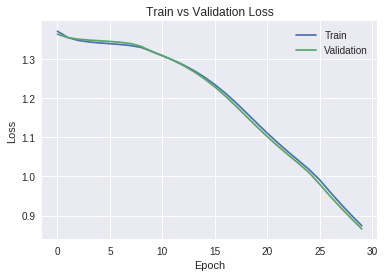

In [42]:
cnn.compile(loss='categorical_crossentropy', optimizer='sgd', metrics = ['accuracy'])
history = cnn.fit(X_train, y_train, epochs=30, validation_split=0.1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [0]:
predictions = cnn.predict(X_test)

In [187]:
predictions.shape

(16, 32, 32, 4)

In [0]:
predictions = predictions.reshape((16384,4))

In [0]:
pred = predictions[:,0:3]

In [0]:
for i in range(len(predictions)):
    pred[i] = kmeans.cluster_centers_[np.argmax(predictions[i])].tolist()

In [0]:
pred = pred.reshape((16,32,32,3))

### Original Test Values

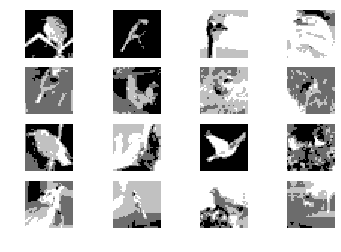

In [195]:
for i in range(0,16):
    axis = plt.subplot(4,4,i+1)
    arr = X_test.reshape(16,32,32)[i]
    axis.imshow(arr)
    plt.axis('off')
plt.show()

### Predicted Values (Note the colors are messed up due to the floating point conversion. I tried fixing it a lot but did not happen. You can check that it's predicting the cluster centers in the code after the images)

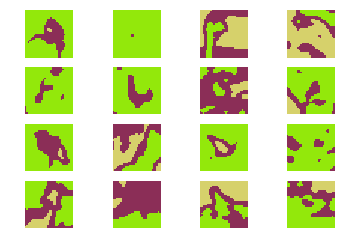

In [197]:
for i in range(0,16):
    axis = plt.subplot(4,4,i+1)
    arr = pred[i]
    axis.imshow(arr)
    plt.axis('off')
plt.show()

### Predicts the cluster centers

In [199]:
pred[0]

array([[[156.18468, 155.5164 , 135.57286],
        [156.18468, 155.5164 , 135.57286],
        [156.18468, 155.5164 , 135.57286],
        ...,
        [156.18468, 155.5164 , 135.57286],
        [156.18468, 155.5164 , 135.57286],
        [156.18468, 155.5164 , 135.57286]],

       [[156.18468, 155.5164 , 135.57286],
        [156.18468, 155.5164 , 135.57286],
        [156.18468, 155.5164 , 135.57286],
        ...,
        [156.18468, 155.5164 , 135.57286],
        [156.18468, 155.5164 , 135.57286],
        [156.18468, 155.5164 , 135.57286]],

       [[156.18468, 155.5164 , 135.57286],
        [156.18468, 155.5164 , 135.57286],
        [156.18468, 155.5164 , 135.57286],
        ...,
        [156.18468, 155.5164 , 135.57286],
        [156.18468, 155.5164 , 135.57286],
        [156.18468, 155.5164 , 135.57286]],

       ...,

       [[156.18468, 155.5164 , 135.57286],
        [156.18468, 155.5164 , 135.57286],
        [156.18468, 155.5164 , 135.57286],
        ...,
        [156.18468, 155.51